# Challenge 1 : NLP 文本分類

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
%matplotlib inline

In [2]:
train_data = pd.read_csv('01_Hoteltrain.csv')
test_data = pd.read_csv('01_Hoteltest.csv')

### 先觀察訓練及測試資料集

In [3]:
train_data.head()

,index,label,review
0,1,0,"來往虹橋機場,絕對方便,938公共汽車直接門對門,上車睡覺就可以了(一個半小時)賓館服務不專..."
1,2,1,來武漢出差很多次了，這次經朋友介紹，住在海怡錦江大酒店。外表看來的確一般，但住進去後，感覺還...
2,3,0,來長春之前，查閱了攜程的很多酒店評分，感覺這個還算不錯的，但是入住之後感覺很失望：1、房間門...
3,4,1,來蘇州好多次了，基本上都住在這家酒店。給我的感覺非常好，房間很乾淨，設施也很全，各種用品也很...
4,5,1,依海而建，地理位置絕佳，旁邊就是星海廣場。床特別大，很舒適，房間裡有咖啡包，但有一天服務生忘...


In [4]:
train_data.shape

(5000, 3)

In [5]:
train_data['label'].value_counts()

1    3421
0    1579
Name: label, dtype: int64

In [6]:
test_data.head()

,index,label,review
0,1,0.5,"""此期間預訂，入住首日酒店贈送每間房10元洗衣券一張，通過攜程預訂，入住首日每房還可獲贈歡迎..."
1,2,0.5,&#35828;&#23454;&#35805;，&#23545;景&#21306;酒店的硬...
2,3,0.5,(1)房間衛生乾淨空間大!(2)早餐美味風富菜色多!
3,4,0.5,（1）酒店冊子介紹說房間內提供飲用水，水壺內沒有水，給前臺提意見。前臺說飲用水就是衛生間的自...
4,5,0.5,*房間很不錯，服務很好，就是位置偏點，在機場到市區的路邊，打車到江北商業圈起步價。*早餐不錯。


In [7]:
test_data.shape

(2765, 3)

## 1. 進行分詞及整理文本

#### 由於評論是繁體中文，因此使用先前清大深度學習課程所提供的 'big5_dict.txt' 並利用 jieba 套件進行分詞

In [8]:
import jieba
jieba.set_dictionary('big5_dict.txt')

In [9]:
def cutwords(x) :
    
    res = []
    
    for i in range(len(x)) :
        
        res.append(jieba.lcut(x[i]))
      
    return res    

In [10]:
cut_train = cutwords(train_data['review'])
cut_test = cutwords(test_data['review'])

Building prefix dict from C:\Users\a0972\Desktop\CTBC\big5_dict.txt ...
Loading model from cache C:\Users\a0972\AppData\Local\Temp\jieba.u85eb49a89a55b5bf4a5bc6fb4aafef52.cache
Loading model cost 0.431 seconds.
Prefix dict has been built succesfully.


#### 為了使文本更加乾淨，刪除斷詞及符號。
#### 其中 'stopwords.txt' 的來源為 : 
https://github.com/tomlinNTUB/Python-in-5-days/blob/master/10-2%20%E4%B8%AD%E6%96%87%E6%96%B7%E8%A9%9E-%E7%A7%BB%E9%99%A4%E5%81%9C%E7%94%A8%E8%A9%9E.md

In [11]:
stopwords = []
with open('stopwords.txt', 'r', encoding='UTF-8') as file:
    for data in file.readlines():
        data = data.strip()
        stopwords.append(data)

In [12]:
def clean_text(x, stopwords) :
    
    res = []
    
    for i in range(len(x)) :
        
        r1 = list(filter(lambda a: a not in stopwords and a != '\n', x[i]))
        
        r2 = [y for y in r1 if not (y.replace(".", "", 1).isdigit() or y[0] == '-' or y[1:].replace(".", "", 1).isdigit() or y[:-1].replace(".", "", 1).isdigit())]
        
        res.append(r2)
        
    return res

In [13]:
clean_train = clean_text(cut_train, stopwords)
clean_test = clean_text(cut_test, stopwords)

#### 由以下統計量及直方圖可以發現，在經過分詞及篩選後，訓練和測試資料的評論長度大部分少於 100 

In [14]:
pd.DataFrame({'text length' : [len(x) for x in clean_train]}).describe()

,text length
count,5000.000000
mean,39.335800
std,41.514886
min,1.000000
25%,14.000000
50%,26.000000
75%,48.000000
max,493.000000


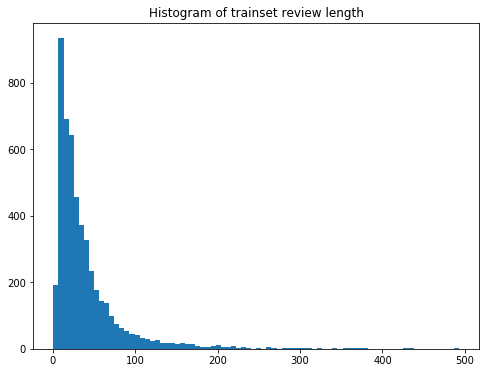

In [15]:
plt.figure(figsize = (8, 6))
plt.hist([len(x) for x in clean_train], bins = 80)
plt.title('Histogram of trainset review length')
plt.show()

In [16]:
pd.DataFrame({'text length' : [len(x) for x in clean_test]}).describe()

,text length
count,2765.000000
mean,49.155154
std,55.526999
min,0.000000
25%,18.000000
50%,32.000000
75%,60.000000
max,948.000000


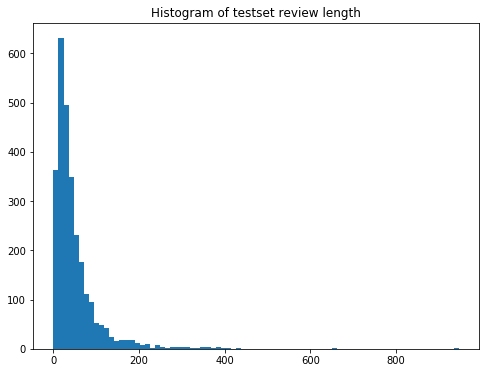

In [17]:
plt.figure(figsize = (8, 6))
plt.hist([len(x) for x in clean_test], bins = 80)
plt.title('Histogram of testset review length')
plt.show()

## 2. 以 LSTM 訓練飯店評論文本分類 

In [18]:
import tensorflow as tf
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '0'

#let the gpu allocates memory space dynamically
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

C:\Users\a0972\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [19]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Dropout, Bidirectional
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import optimizers

Using TensorFlow backend.


#### 由於評論中形容詞占大部分也較為重要，因此我只挑前1000高的詞彙進行 token，又考慮評論長度大部分小於100，
#### 再考慮 75% 位數後，決定每個評論擷取 80 個詞，不足以 padding 補齊。

In [20]:
MAX_NB_WORDS = 1000

MAX_SEQUENCE_LENGTH = 80

EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words = MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(clean_train)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 21789 unique tokens.


In [21]:
X = tokenizer.texts_to_sequences(clean_train)
X = pad_sequences(X, maxlen = MAX_SEQUENCE_LENGTH)
Y = train_data['label']

#### 訓練模型為 LSTM ，每個 cell 餵進可訓練的分詞向量，分詞向量長度為 100，LSTM 最後輸出長度 50 之向量。
#### 並再過程中加上 Dropout 防止過度配適，最後一層的激活函數為 sigmoid ，長度為 1 ，以近進行分類。
#### 最後隨機選取10%的訓練資料作為 valid set。

In [22]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1], trainable=True))
# model.add(SpatialDropout1D(0.2))
model.add(LSTM(50, dropout=0.2, recurrent_dropout=0.2))
# model.add(Dense(50, activation='relu'))
model.add(Dropout(0.1))
# model.add(Dense(10))
model.add(Dense(1, activation='sigmoid'))
optimizer = optimizers.Adam(lr=0.0005, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0001, amsgrad=False)
model.compile(loss = 'binary_crossentropy', optimizer = optimizer, metrics = ['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 80, 100)           100000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                30200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 130,251
Trainable params: 130,251
Non-trainable params: 0
_________________________________________________________________
None


#### valid set 的分類準確度最高達 91.4%，儲存最佳模型。

In [23]:
epochs = 100

batch_size = 50

weight_save = ModelCheckpoint('01_Hotel_weight.hdf5', save_best_only=True, monitor='val_loss', mode='min')

model.fit(X, Y, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience = 1, min_delta=0.0001), weight_save])

Train on 4500 samples, validate on 500 samples
Epoch 1/100
4500/4500 [==============================] - 13s 3ms/step - loss: 0.6255 - acc: 0.6651 - val_loss: 0.4506 - val_acc: 0.8400
Epoch 2/100
4500/4500 [==============================] - 11s 2ms/step - loss: 0.4298 - acc: 0.8073 - val_loss: 0.2964 - val_acc: 0.8860
Epoch 3/100
4500/4500 [==============================] - 10s 2ms/step - loss: 0.3198 - acc: 0.8673 - val_loss: 0.2909 - val_acc: 0.8620
Epoch 4/100
4500/4500 [==============================] - 10s 2ms/step - loss: 0.2839 - acc: 0.8856 - val_loss: 0.2663 - val_acc: 0.8800
Epoch 5/100
4500/4500 [==============================] - 10s 2ms/step - loss: 0.2571 - acc: 0.8960 - val_loss: 0.2282 - val_acc: 0.9140
Epoch 6/100
4500/4500 [==============================] - 10s 2ms/step - loss: 0.2411 - acc: 0.9060 - val_loss: 0.2463 - val_acc: 0.8940


#### 對測試資料進行分類

In [24]:
seq = tokenizer.texts_to_sequences(clean_test)
padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)

model.load_weights('01_Hotel_weight.hdf5')
pred = model.predict(padded)

pred[pred >= 0.5] = 1
pred[pred < 0.5] = 0

test_data['label'] = pred
test_data.head()

,index,label,review
0,1,1.0,"""此期間預訂，入住首日酒店贈送每間房10元洗衣券一張，通過攜程預訂，入住首日每房還可獲贈歡迎..."
1,2,0.0,&#35828;&#23454;&#35805;，&#23545;景&#21306;酒店的硬...
2,3,1.0,(1)房間衛生乾淨空間大!(2)早餐美味風富菜色多!
3,4,0.0,（1）酒店冊子介紹說房間內提供飲用水，水壺內沒有水，給前臺提意見。前臺說飲用水就是衛生間的自...
4,5,1.0,*房間很不錯，服務很好，就是位置偏點，在機場到市區的路邊，打車到江北商業圈起步價。*早餐不錯。


In [25]:
test_data.to_csv('./submit/01_Hoteltest.csv', index = False, encoding='utf_8_sig')